# Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import seaborn as sns
sns.set_style('darkgrid')

from sklearn.preprocessing import MinMaxScaler

# Deep learning libraries
import tensorflow as tf
import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, LSTM, Dropout

import warnings
warnings.filterwarnings('ignore')

# Reading The Data

In [2]:
data_dir = '/kaggle/input/bitcoin-prediction-dataset-bullrun/BTC_USD_Price_Prediction_Data.csv'
df = pd.read_csv(data_dir, parse_dates=True, index_col='Date')

# Data Exploration

In [3]:
df.head()

,Unnamed: 0,Currency,Closing Price (USD),24h Open (USD),24h High (USD),24h Low (USD)
Date,,,,,,
2014-03-14,0,BTC,124.65499,125.30466,125.75166,123.56349
2014-03-15,1,BTC,126.45500,124.65499,126.75850,124.63383
2014-03-16,2,BTC,109.58483,126.45500,126.66566,84.32833
2014-03-17,3,BTC,119.67466,109.58483,119.67500,108.05816
2014-03-18,4,BTC,122.33866,119.67466,122.93633,119.00566


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2787 entries, 2014-03-14 to 2021-10-29
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Unnamed: 0           2787 non-null   int64  
 1   Currency             2787 non-null   object 
 2   Closing Price (USD)  2787 non-null   float64
 3   24h Open (USD)       2787 non-null   float64
 4   24h High (USD)       2787 non-null   float64
 5   24h Low (USD)        2787 non-null   float64
dtypes: float64(4), int64(1), object(1)
memory usage: 152.4+ KB


In [5]:
df.describe().round(2)

,Unnamed: 0,Closing Price (USD),24h Open (USD),24h High (USD),24h Low (USD)
count,2787.00,2787.00,2787.00,2787.00,2787.00
mean,1393.00,6530.85,6514.58,6711.06,6303.42
std,804.68,10887.85,10863.80,11206.78,10475.81
min,0.00,109.58,109.58,119.68,84.33
25%,696.50,461.09,460.40,470.72,451.82
50%,1393.00,2781.18,2773.37,2875.70,2697.46
75%,2089.50,8507.92,8497.89,8764.29,8222.06
max,2786.00,63347.79,63563.67,64802.79,62095.63


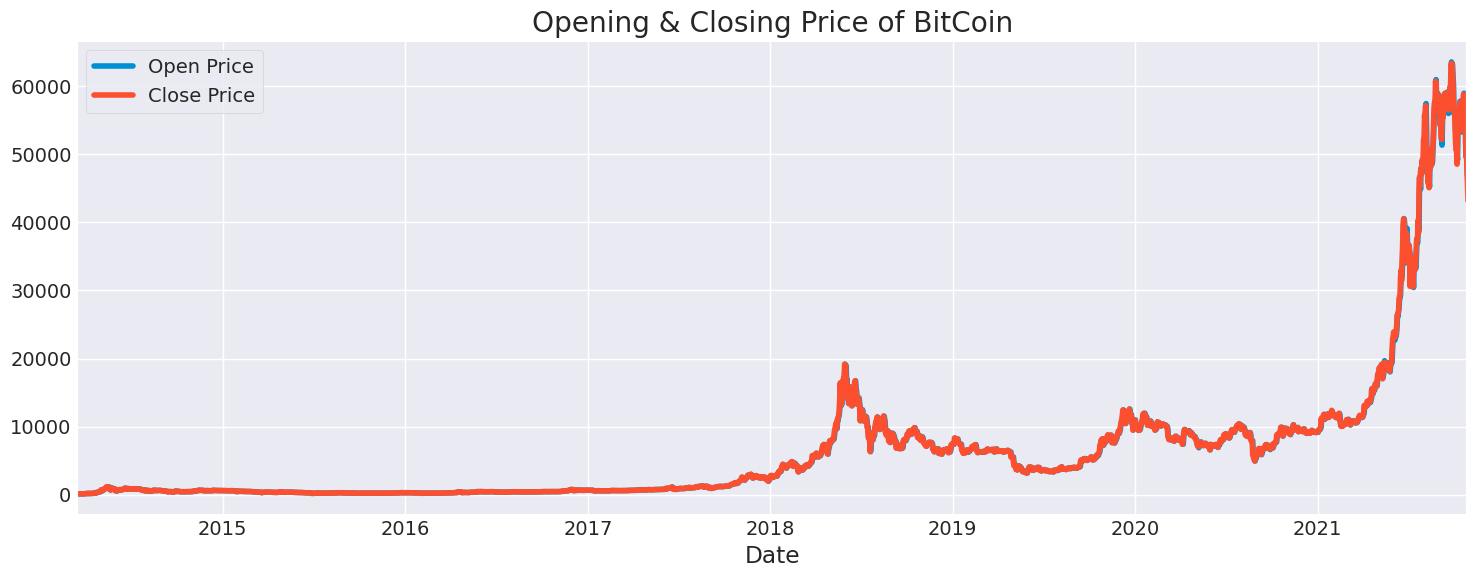

In [6]:
plt.figure(figsize=(15, 6))
df['24h Open (USD)'].plot()
df['Closing Price (USD)'].plot()
plt.title("Opening & Closing Price of BitCoin")
plt.legend(['Open Price', 'Close Price'])
plt.tight_layout()
plt.show()

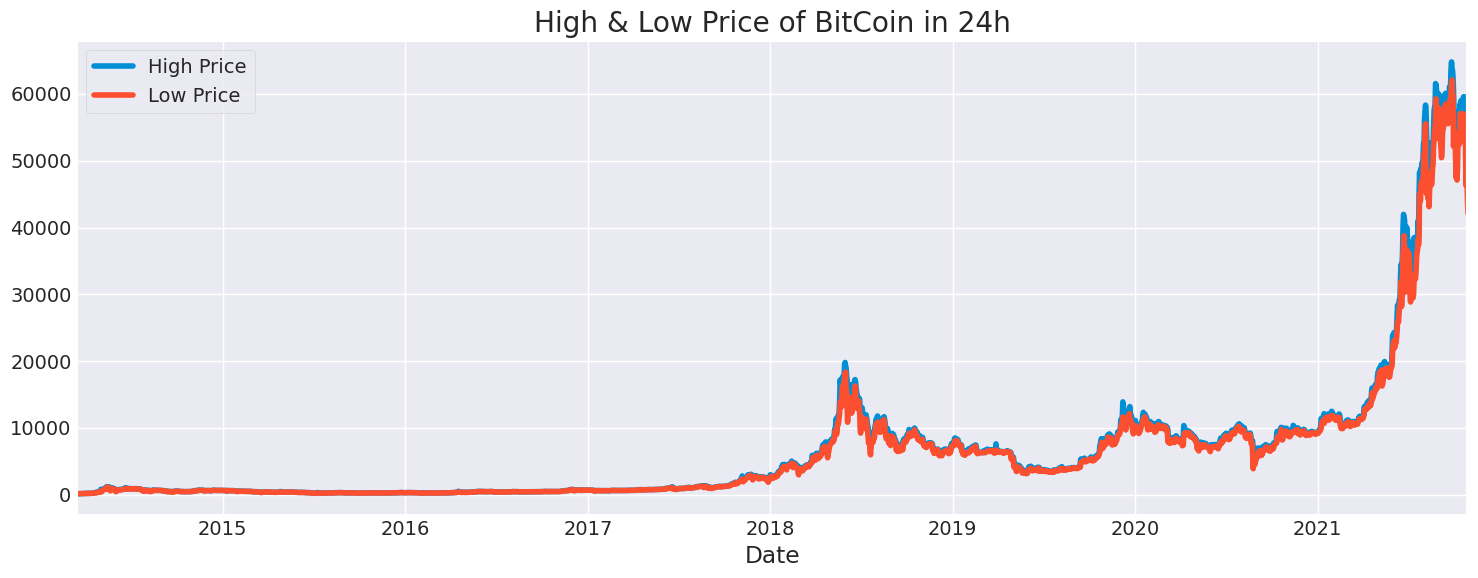

In [7]:
plt.figure(figsize=(15, 6))
df['24h High (USD)'].plot()
df['24h Low (USD)'].plot()
plt.title("High & Low Price of BitCoin in 24h")
plt.legend(['High Price', 'Low Price'])
plt.tight_layout()
plt.show()

# Data Preprocessing

## Choosing Prediction Column

In [8]:
dataset = df['Closing Price (USD)']
dataset = pd.DataFrame(dataset)

data = dataset.values
data.shape

(2787, 1)

## Normalizing Data

In [9]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(data)

## Splitting the Data

In [10]:
# 75% to Train , 25% to Test
train_size = int(len(data) * .75)
test_size = len(data) - train_size
print("Train Size :",train_size,"Test Size :",test_size)

Train Size : 2090 Test Size : 697


In [11]:
train_data = scaled_data[:train_size, :]
test_data = scaled_data[train_size-60: , :]

In [12]:
train_data.shape , test_data.shape

((2090, 1), (757, 1))

## Creating training set

In [13]:
# Creating a Training Set with 60 time-steps and 1 output
x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60 : i, 0])
    y_train.append(train_data[i, 0])

In [14]:
# Convert to numpy array 
x_train, y_train = np.array(x_train), np.array(y_train)

In [15]:
# Reshaping the input
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [16]:
x_train.shape , y_train.shape

((2030, 60, 1), (2030,))

# LSTM Model

## Model Structure

In [17]:
model = Sequential([
    LSTM(50, return_sequences=True, input_shape = (x_train.shape[1], 1)),
    LSTM(64, return_sequences=False),
    
    Dense(32),
    Dense(16),
    Dense(1)
])

model.compile(optimizer= 'adam', loss= 'mse' , metrics= ["mean_absolute_error"])

In [18]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        29,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 42,465 (165.88 KB)

 Trainable params: 42,465 (165.88 KB)

 Non-trainable params: 0 (0.00 B)

## Model Training

In [19]:
early_stopping = EarlyStopping(
    patience=10,
    monitor='loss',
    restore_best_weights=True
)

In [20]:
# Fitting the LSTM to the Training set
history = model.fit(x_train, y_train, epochs=100, batch_size=32, callbacks=early_stopping)

Epoch 1/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - loss: 4.9908e-04 - mean_absolute_error: 0.0135
Epoch 2/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - loss: 8.2139e-05 - mean_absolute_error: 0.0059
Epoch 3/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - loss: 8.1850e-05 - mean_absolute_error: 0.0053
Epoch 4/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - loss: 6.3184e-05 - mean_absolute_error: 0.0050
Epoch 5/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - loss: 5.9831e-05 - mean_absolute_error: 0.0045
Epoch 6/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - loss: 4.7194e-05 - mean_absolute_error: 0.0041
Epoch 7/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - loss: 6.9958e-05 - mean_absolute_error: 0.0051
Epoch 8/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - loss: 4.8578e-05 - mean_absolute_error: 0.0034
Epoch 9/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - loss: 5.7333e-05 - mean_absolute_error: 0.0046
Epoch 10/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - loss: 4.6861e-05 - mean_absolute_err

## Model Evaluation

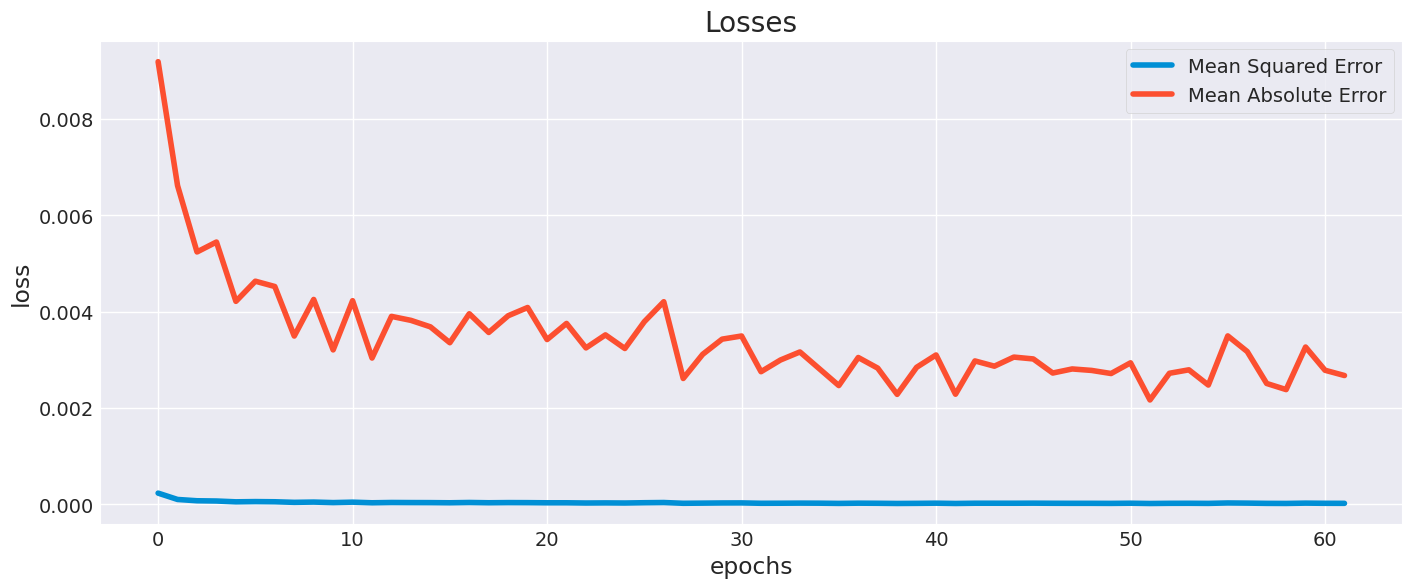

In [21]:
plt.figure(figsize=(15,6))
plt.plot(history.history['loss'])
plt.plot(history.history['mean_absolute_error'])
plt.legend(['Mean Squared Error', 'Mean Absolute Error'])
plt.title('Losses')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()

# Predection

## Creating testing set

In [22]:
# Creating a testing set with 60 time-steps and 1 output
x_test = []
y_test = []

for i in range(60, len(test_data)):
    x_test.append(test_data[i-60 : i, 0])
    y_test.append(test_data[i, 0])

In [23]:
x_test, y_test = np.array(x_test), np.array(y_test)

In [24]:
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [25]:
x_test.shape , y_test.shape

((697, 60, 1), (697,))

In [26]:
# inverse y_test scaling 
predictions = model.predict(x_test)

22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step


In [27]:
# inverse predictions scaling 
predictions = scaler.inverse_transform(predictions)
predictions.shape

(697, 1)

## Root mean square error

In [28]:
# inverse y_test scaling 
y_test = scaler.inverse_transform([y_test])

RMSE = np.sqrt(np.mean( y_test - predictions )**2).round(2)
RMSE

721.16

In [29]:
preds_acts = pd.DataFrame(data={'Predictions':predictions.flatten(), 'Actuals':y_test.flatten()})
preds_acts

,Predictions,Actuals
0,9449.199219,9907.407965
1,9790.529297,10462.412169
2,10310.880859,10844.570975
3,10704.466797,10997.459750
4,10874.741211,11666.409684
...,...,...
692,47836.207031,49765.132082
693,45852.207031,50033.693137
694,46662.312500,47886.625255
695,44473.234375,45605.615754


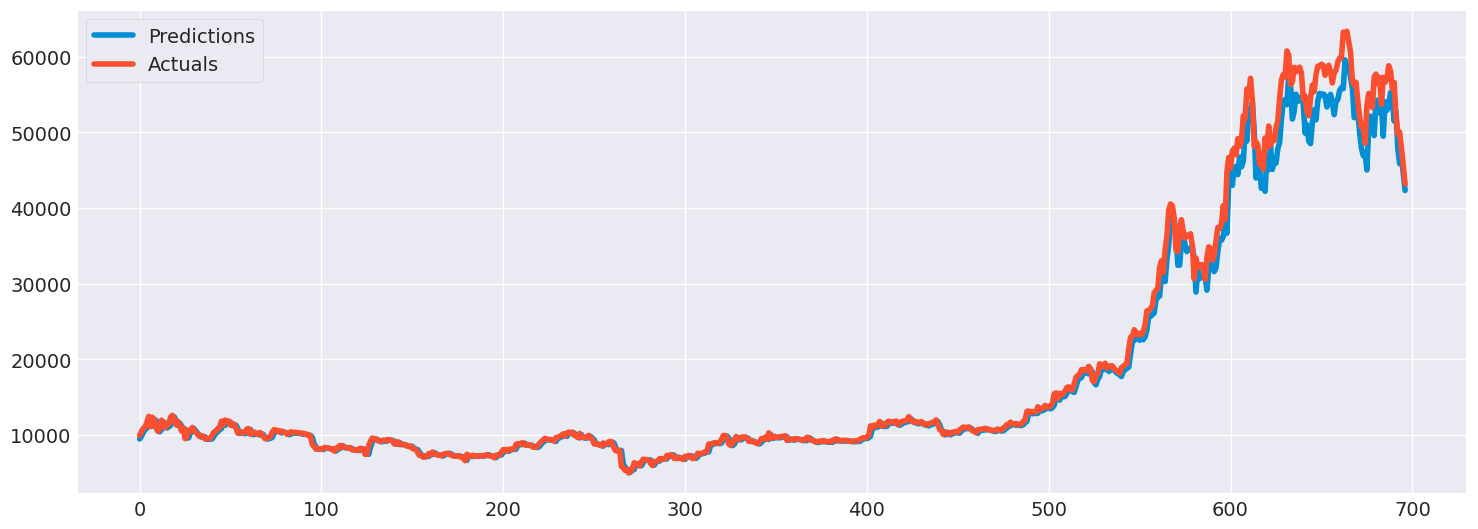

In [30]:
plt.figure(figsize = (16, 6))
plt.plot(preds_acts['Predictions'])
plt.plot(preds_acts['Actuals'])
plt.legend(['Predictions', 'Actuals'])
plt.show()

## Visualize Predictions with The Data

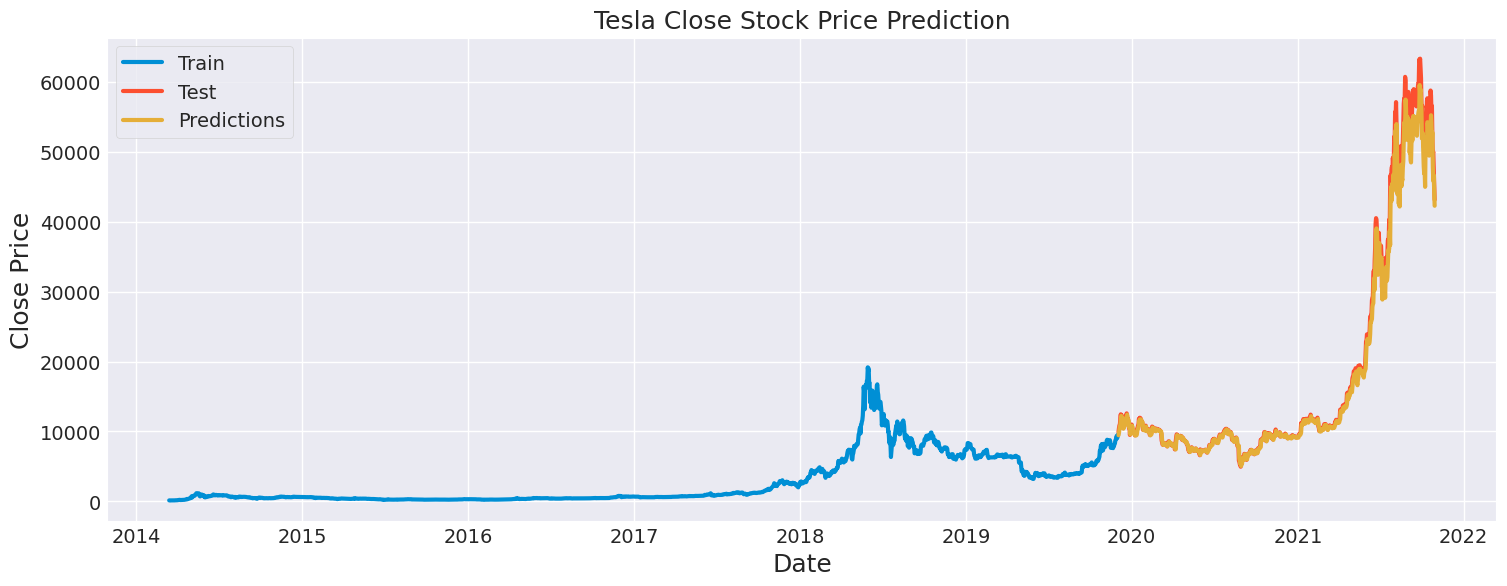

In [31]:
train = dataset.iloc[:train_size , 0:1]
test = dataset.iloc[train_size: , 0:1]
test['Predictions'] = predictions

plt.figure(figsize= (16, 6))
plt.title('Tesla Close Stock Price Prediction', fontsize= 18)
plt.xlabel('Date', fontsize= 18)
plt.ylabel('Close Price', fontsize= 18)
plt.plot(train[r'Closing Price (USD)'], linewidth= 3)
plt.plot(test[r'Closing Price (USD)'], linewidth= 3)
plt.plot(test["Predictions"], linewidth= 3)
plt.legend(['Train', 'Test', 'Predictions'])

# Forecast Next 30 Days

In [32]:
from datetime import timedelta

In [33]:
def insert_end(Xin, new_input):
    timestep = 60 
    for i in range(timestep - 1):    
        Xin[:, i, :] = Xin[:, i+1, :]
    Xin[:, timestep-1, :] = new_input
    return Xin

In [34]:
future = 30
forecast = []
Xin = x_test[-1:, :, :]
time = []

for i in range(0, future):
    out = model.predict(Xin, batch_size=5)
    forecast.append(out[0,0])
    print(forecast)
    Xin = insert_end(Xin, out[0,0])
    time.append(pd.to_datetime(df.index[-1]) + timedelta(days=i))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
[0.66708696]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
[0.66708696, 0.6165541]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
[0.66708696, 0.6165541, 0.5702648]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
[0.66708696, 0.6165541, 0.5702648, 0.5290769]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
[0.66708696, 0.6165541, 0.5702648, 0.5290769, 0.49289522]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
[0.66708696, 0.6165541, 0.5702648, 0.5290769, 0.49289522, 0.46116257]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
[0.66708696, 0.6165541, 0.5702648, 0.5290769, 0.49289522, 0.46116257, 0.43321064]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
[0.66708696, 0.6165541, 0.5702648, 0.5290769, 0.49289522, 0.46116257, 0.43321064, 0.40843308]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
[0.66708696, 0.6165541, 0.5702648, 0.5290769, 0.49289522, 0.46116257, 0.43321064, 0.40843308, 0.3863418]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
[0.66708696, 0.6165541, 0.5702648, 0.5290769, 0.49289522, 0.46116257, 0.43321064, 0.40843308,

In [35]:
time

[Timestamp('2021-10-29 00:00:00'),
 Timestamp('2021-10-30 00:00:00'),
 Timestamp('2021-10-31 00:00:00'),
 Timestamp('2021-11-01 00:00:00'),
 Timestamp('2021-11-02 00:00:00'),
 Timestamp('2021-11-03 00:00:00'),
 Timestamp('2021-11-04 00:00:00'),
 Timestamp('2021-11-05 00:00:00'),
 Timestamp('2021-11-06 00:00:00'),
 Timestamp('2021-11-07 00:00:00'),
 Timestamp('2021-11-08 00:00:00'),
 Timestamp('2021-11-09 00:00:00'),
 Timestamp('2021-11-10 00:00:00'),
 Timestamp('2021-11-11 00:00:00'),
 Timestamp('2021-11-12 00:00:00'),
 Timestamp('2021-11-13 00:00:00'),
 Timestamp('2021-11-14 00:00:00'),
 Timestamp('2021-11-15 00:00:00'),
 Timestamp('2021-11-16 00:00:00'),
 Timestamp('2021-11-17 00:00:00'),
 Timestamp('2021-11-18 00:00:00'),
 Timestamp('2021-11-19 00:00:00'),
 Timestamp('2021-11-20 00:00:00'),
 Timestamp('2021-11-21 00:00:00'),
 Timestamp('2021-11-22 00:00:00'),
 Timestamp('2021-11-23 00:00:00'),
 Timestamp('2021-11-24 00:00:00'),
 Timestamp('2021-11-25 00:00:00'),
 Timestamp('2021-11-

## Create Forecasted Dataframe

In [36]:
forecasted_output = np.array(forecast)
forecasted_output = forecasted_output.reshape(-1,1)
forecasted_output = scaler.inverse_transform(forecasted_output)

In [37]:
forecasted_output = pd.DataFrame(forecasted_output)
date = pd.DataFrame(time)
df_result = pd.concat([date, forecasted_output], axis=1)
df_result.columns = 'Date', 'Forecasted'

## Forecasted BitCoin close price

In [38]:
df_result

,Date,Forecasted
0,2021-10-29,42294.964844
1,2021-10-30,39099.359375
2,2021-10-31,36172.109375
3,2021-11-01,33567.457031
4,2021-11-02,31279.392578
5,2021-11-03,29272.677734
6,2021-11-04,27505.046875
7,2021-11-05,25938.158203
8,2021-11-06,24541.146484
9,2021-11-07,23290.410156


In [39]:
df_result.set_index('Date', inplace=True)

In [40]:
df_result

,Forecasted
Date,
2021-10-29,42294.964844
2021-10-30,39099.359375
2021-10-31,36172.109375
2021-11-01,33567.457031
2021-11-02,31279.392578
2021-11-03,29272.677734
2021-11-04,27505.046875
2021-11-05,25938.158203
2021-11-06,24541.146484


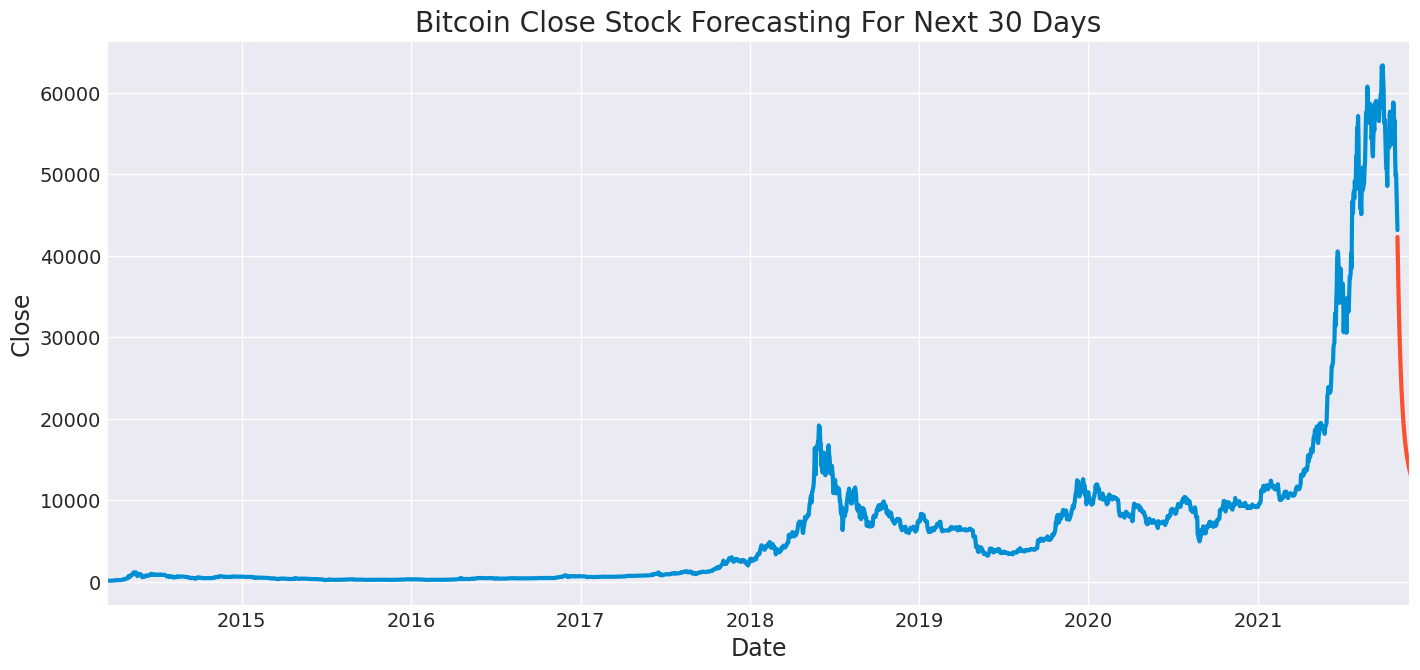

In [41]:
plt.figure(figsize=(15,7))
df['Closing Price (USD)'].plot(linewidth=3)
df_result['Forecasted'].plot(linewidth=3)
plt.title('Bitcoin Close Stock Forecasting For Next 30 Days')
plt.xlabel('Date', fontsize = 17)
plt.ylabel('Close', fontsize = 17)
plt.show()

# Multivariate Predection

In [42]:
df.head()

,Unnamed: 0,Currency,Closing Price (USD),24h Open (USD),24h High (USD),24h Low (USD)
Date,,,,,,
2014-03-14,0,BTC,124.65499,125.30466,125.75166,123.56349
2014-03-15,1,BTC,126.45500,124.65499,126.75850,124.63383
2014-03-16,2,BTC,109.58483,126.45500,126.66566,84.32833
2014-03-17,3,BTC,119.67466,109.58483,119.67500,108.05816
2014-03-18,4,BTC,122.33866,119.67466,122.93633,119.00566


## Choosing Prediction Column

In [43]:
list(df.columns[2:])

['Closing Price (USD)', '24h Open (USD)', '24h High (USD)', '24h Low (USD)']

In [44]:
cols = list(df.columns[2:])
dataset = df[cols]

data = dataset.values
data.shape

(2787, 4)

In [45]:
dataset

,Closing Price (USD),24h Open (USD),24h High (USD),24h Low (USD)
Date,,,,
2014-03-14,124.654990,125.304660,125.751660,123.563490
2014-03-15,126.455000,124.654990,126.758500,124.633830
2014-03-16,109.584830,126.455000,126.665660,84.328330
2014-03-17,119.674660,109.584830,119.675000,108.058160
2014-03-18,122.338660,119.674660,122.936330,119.005660
...,...,...,...,...
2021-10-25,49765.132082,49597.778891,51449.798576,46295.720180
2021-10-26,50033.693137,49718.354353,51579.312545,48945.346536
2021-10-27,47886.625255,49927.035067,50691.802950,47006.102292


In [46]:
data

array([[  124.65499   ,   125.30466   ,   125.75166   ,   123.56349   ],
       [  126.455     ,   124.65499   ,   126.7585    ,   124.63383   ],
       [  109.58483   ,   126.455     ,   126.66566   ,    84.32833   ],
       ...,
       [47886.62525472, 49927.03506746, 50691.80294954, 47006.10229248],
       [45605.61575361, 46806.53785192, 49671.41417381, 43869.63896927],
       [43145.47129086, 46440.3365698 , 46623.85343748, 42103.34642962]])

## Normalizing Data

In [47]:
scaled_data = scaler.fit_transform(data)

## Splitting the Data

In [48]:
train_size = int(len(data) * 0.75)
test_size = len(data) - train_size
print("Train Size :",train_size,"Test Size :",test_size)

Train Size : 2090 Test Size : 697


In [49]:
train_data = scaled_data[:train_size, :]
test_data = scaled_data[train_size-60:, :]

In [50]:
train_data.shape, test_data.shape

((2090, 4), (757, 4))

## Creating training set

In [51]:
# Creating a Training set with 60 time-steps
x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, :4])
    y_train.append(train_data[i, :4])

In [52]:
# Convert to numpy array 
x_train, y_train = np.array(x_train) , np.array(y_train)

In [53]:
# Reshaping the input
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 4))

In [54]:
x_train.shape, y_train.shape

((2030, 60, 4), (2030, 4))

## Model Structure

In [55]:
model2 = Sequential([
    LSTM(50, return_sequences=True, input_shape = (x_train.shape[1], 4)),
    LSTM(64, return_sequences=False),
    
    Dense(32),
    Dense(16),
    Dense(4)
])

model2.compile(optimizer='adam', loss= 'mse', metrics=['mean_absolute_error'])

In [56]:
model2.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 60, 50)         │        11,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 64)             │        29,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 4)              │            68 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 43,116 (168.42 KB)

 Trainable params: 43,116 (168.42 KB)

 Non-trainable params: 0 (0.00 B)

## Model Training

In [57]:
early_stopping = EarlyStopping(
    patience=10,
    monitor='loss',
    restore_best_weights=True
)

In [58]:
# Fitting the LSTM to the Training set
history2 = model2.fit(x_train, y_train, epochs=100, batch_size=32, callbacks=early_stopping)

Epoch 1/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - loss: 8.9967e-04 - mean_absolute_error: 0.0190
Epoch 2/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - loss: 8.0597e-05 - mean_absolute_error: 0.0051
Epoch 3/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - loss: 7.1285e-05 - mean_absolute_error: 0.0048
Epoch 4/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - loss: 4.8164e-05 - mean_absolute_error: 0.0041
Epoch 5/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - loss: 5.0948e-05 - mean_absolute_error: 0.0044
Epoch 6/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - loss: 5.3907e-05 - mean_absolute_error: 0.0048
Epoch 7/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - loss: 4.1906e-05 - mean_absolute_error: 0.0039
Epoch 8/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - loss: 4.1423e-05 - mean_absolute_error: 0.0038
Epoch 9/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - loss: 3.5638e-05 - mean_absolute_error: 0.0035
Epoch 10/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - loss: 4.3513e-05 - mean_absolute_err

## Model Evaluation

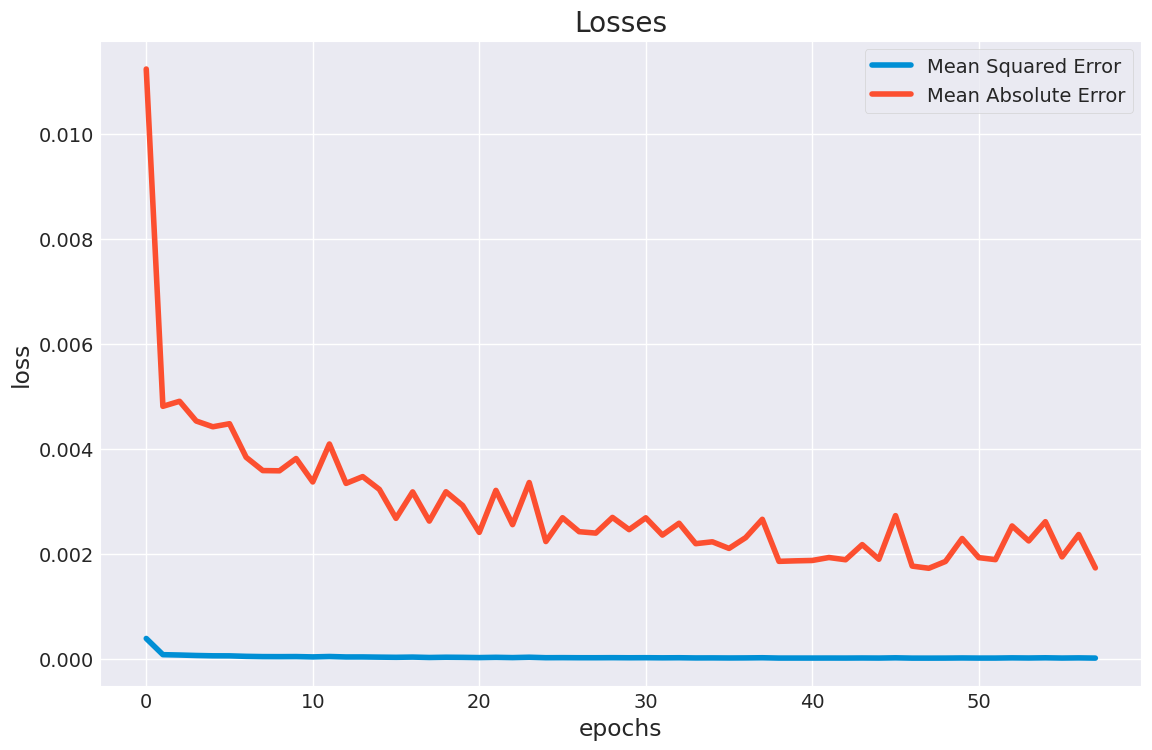

In [59]:
plt.figure(figsize=(12, 8))
plt.plot(history2.history["loss"])
plt.plot(history2.history["mean_absolute_error"])
plt.legend(['Mean Squared Error','Mean Absolute Error'])
plt.title("Losses")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

## Predection

### Creating testing set

In [60]:
# Creating a Testing Set with 60 time-steps and 1 output
x_test = []
y_test = []

for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, :4])
    y_test.append(test_data[i,:4])

In [61]:
x_test , y_test = np.array(x_test), np.array(y_test)

In [62]:
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 4))

In [63]:
x_test.shape , y_test.shape

((697, 60, 4), (697, 4))

In [64]:
# inverse y_test scaling 
predictions = model2.predict(x_test)

# inverse predictions scaling 
predictions = scaler.inverse_transform(predictions)
predictions.shape

22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step


(697, 4)

## Root mean square error

In [65]:
# inverse y_test scaling 
y_test = scaler.inverse_transform(y_test)

RMSE = np.sqrt(np.mean(y_test - predictions)**2).round(2)
RMSE

1209.7

## Forecast Next 30 Days

In [66]:
def insert_end(Xin, new_input):
    timestep = 60
    for i in range(timestep - 1):
        Xin[:, i, :] = Xin[:, i+1, :]
    Xin[:, timestep - 1, :] = new_input
    return Xin

In [67]:
future = 30
forcast = []
Xin = x_test[-1 :, :, :]
time = []

for i in range(0, future):
    out = model2.predict(Xin, batch_size=5)
    forcast.append(out[0]) 
    print(forcast)
    Xin = insert_end(Xin, out[0, 0]) 
    time.append(pd.to_datetime(df.index[-1]) + timedelta(days=i))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
[array([0.5876829 , 0.6563583 , 0.68741953, 0.51294535], dtype=float32)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
[array([0.5876829 , 0.6563583 , 0.68741953, 0.51294535], dtype=float32), array([0.42740357, 0.48511004, 0.5182145 , 0.35300317], dtype=float32)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
[array([0.5876829 , 0.6563583 , 0.68741953, 0.51294535], dtype=float32), array([0.42740357, 0.48511004, 0.5182145 , 0.35300317], dtype=float32), array([0.29281414, 0.3419634 , 0.37037978, 0.22727993], dtype=float32)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
[array([0.5876829 , 0.6563583 , 0.68741953, 0.51294535], dtype=float32), array([0.42740357, 0.48511004, 0.5182145 , 0.35300317], dtype=float32), array([0.29281414, 0.3419634 , 0.37037978, 0.22727993], dtype=float32), array([0.18586574, 0.22867249, 0.24850264, 0.1329365 ], dtype=float32)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
[array([0.5876829 , 0.6563583 , 0.68741953, 0.51294535], dtype=float32), array([0.4274

In [68]:
time

[Timestamp('2021-10-29 00:00:00'),
 Timestamp('2021-10-30 00:00:00'),
 Timestamp('2021-10-31 00:00:00'),
 Timestamp('2021-11-01 00:00:00'),
 Timestamp('2021-11-02 00:00:00'),
 Timestamp('2021-11-03 00:00:00'),
 Timestamp('2021-11-04 00:00:00'),
 Timestamp('2021-11-05 00:00:00'),
 Timestamp('2021-11-06 00:00:00'),
 Timestamp('2021-11-07 00:00:00'),
 Timestamp('2021-11-08 00:00:00'),
 Timestamp('2021-11-09 00:00:00'),
 Timestamp('2021-11-10 00:00:00'),
 Timestamp('2021-11-11 00:00:00'),
 Timestamp('2021-11-12 00:00:00'),
 Timestamp('2021-11-13 00:00:00'),
 Timestamp('2021-11-14 00:00:00'),
 Timestamp('2021-11-15 00:00:00'),
 Timestamp('2021-11-16 00:00:00'),
 Timestamp('2021-11-17 00:00:00'),
 Timestamp('2021-11-18 00:00:00'),
 Timestamp('2021-11-19 00:00:00'),
 Timestamp('2021-11-20 00:00:00'),
 Timestamp('2021-11-21 00:00:00'),
 Timestamp('2021-11-22 00:00:00'),
 Timestamp('2021-11-23 00:00:00'),
 Timestamp('2021-11-24 00:00:00'),
 Timestamp('2021-11-25 00:00:00'),
 Timestamp('2021-11-

In [69]:
forcast

[array([0.5876829 , 0.6563583 , 0.68741953, 0.51294535], dtype=float32),
 array([0.42740357, 0.48511004, 0.5182145 , 0.35300317], dtype=float32),
 array([0.29281414, 0.3419634 , 0.37037978, 0.22727993], dtype=float32),
 array([0.18586574, 0.22867249, 0.24850264, 0.1329365 ], dtype=float32),
 array([0.10262001, 0.14050168, 0.15059304, 0.06311485], dtype=float32),
 array([0.03830853, 0.07225211, 0.07314202, 0.01134454], dtype=float32),
 array([-0.01086912,  0.01987493,  0.01295245, -0.02701818], dtype=float32),
 array([-0.04790731, -0.01982017, -0.03282844, -0.05528481], dtype=float32),
 array([-0.07529869, -0.04950473, -0.06682938, -0.07595067], dtype=float32),
 array([-0.09515224, -0.07143947, -0.09143752, -0.0909459 ], dtype=float32),
 array([-0.1092229 , -0.08748873, -0.10873844, -0.1017547 ], dtype=float32),
 array([-0.11893383, -0.09913906, -0.12048469, -0.1094988 ], dtype=float32),
 array([-0.12541254, -0.10754186, -0.12810194, -0.11501262], dtype=float32),
 array([-0.12953569, -0

In [70]:
forcasted_output = np.array(forcast)
forcasted_output = scaler.inverse_transform(forcasted_output)

In [71]:
forcasted_output = pd.DataFrame(forcasted_output)
date = pd.DataFrame(time)
df_result = pd.concat([date,forcasted_output], axis=1)
df_result.columns = "Date", 'Closing', 'Open', 'High', 'Low'
df_result.head()

,Date,Closing,Open,High,Low
0,2021-10-29,37273.597656,41758.203125,44584.109375,31892.738281
1,2021-10-30,27137.818359,30891.800781,33639.406250,21974.515625
2,2021-10-31,18626.625000,21808.560547,24076.992188,14178.252930
3,2021-11-01,11863.400391,14619.790039,16193.600586,8327.893555
4,2021-11-02,6599.089844,9024.991211,9860.501953,3998.162598


In [72]:
df_result.set_index('Date', inplace=True)

In [73]:
df_result.head()

,Closing,Open,High,Low
Date,,,,
2021-10-29,37273.597656,41758.203125,44584.109375,31892.738281
2021-10-30,27137.818359,30891.800781,33639.406250,21974.515625
2021-10-31,18626.625000,21808.560547,24076.992188,14178.252930
2021-11-01,11863.400391,14619.790039,16193.600586,8327.893555
2021-11-02,6599.089844,9024.991211,9860.501953,3998.162598


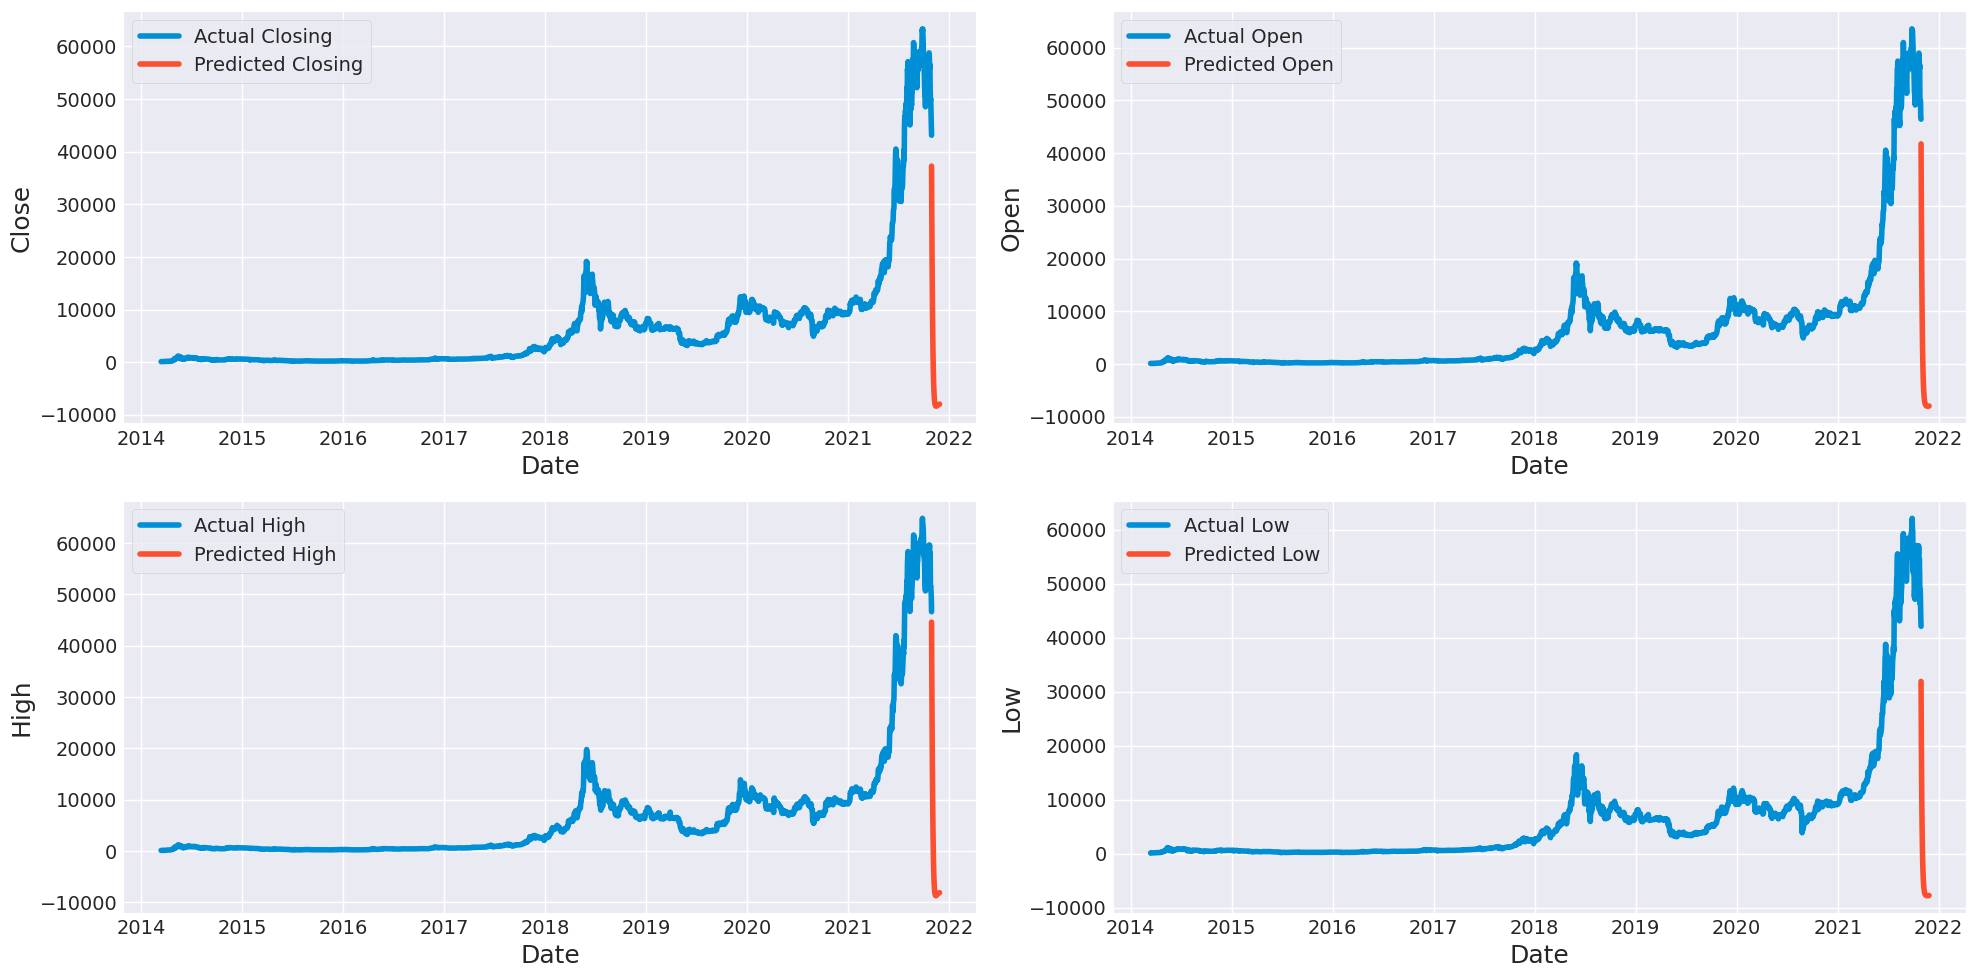

In [74]:
plt.figure(figsize=(20, 10))
plt.title('Next 30 Days')

plt.subplot(2, 2, 1)
plt.plot(df['Closing Price (USD)'], label='Actual Closing')
plt.plot(df_result[['Closing']], label='Predicted Closing')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close' ,fontsize=18)
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(df['24h Open (USD)'], label='Actual Open')
plt.plot(df_result[['Open']], label='Predicted Open')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Open' ,fontsize=18)
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(df['24h High (USD)'], label='Actual High')
plt.plot(df_result[['High']], label='Predicted High')
plt.xlabel('Date', fontsize=18)
plt.ylabel('High' ,fontsize=18)
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(df['24h Low (USD)'], label='Actual Low')
plt.plot(df_result[['Low']], label='Predicted Low')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Low' ,fontsize=18)
plt.legend()

plt.tight_layout()
plt.show()